In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            confusion_matrix, ConfusionMatrixDisplay, roc_curve, 
                            roc_auc_score, classification_report)
from sklearn.preprocessing import StandardScaler, label_binarize
from itertools import cycle


In [2]:

# -----------------------------
# 1. Load Dataset
# -----------------------------
def load_dataset(path='Medical_Device_Failure_dataset.csv'):
    df = pd.read_csv(path)
    if 'Maintenance_Class' not in df.columns:
        raise KeyError("Column 'Maintenance_Class' not found in dataset.")
    return df

# -----------------------------
# 2. Preprocess
# -----------------------------
def preprocess(df):
    features = ['Age', 'Maintenance_Cost', 'Downtime', 'Maintenance_Frequency', 'Failure_Event_Count']
    
    # Derived Features
    df['Cost_per_Event'] = df['Maintenance_Cost'] / (df['Failure_Event_Count'] + 1)
    df['Downtime_per_Frequency'] = df['Downtime'] / (df['Maintenance_Frequency'] + 1)

    features += ['Cost_per_Event', 'Downtime_per_Frequency']

    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])

    X = df[features]
    y = df['Maintenance_Class']
    return X, y, features


In [3]:

# -----------------------------
# 3. Evaluate Individual Models
# -----------------------------
def evaluate_individual_models(X_train, X_test, y_train, y_test, features):
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'SVM': SVC(probability=True, kernel='rbf', gamma='scale', random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Naive Bayes': GaussianNB()
    }
    
    gb_params = {
        'n_estimators': [250, 300, 350],
        'learning_rate': [0.03, 0.05, 0.07],
        'max_depth': [5, 6, 7]
    }
    cv = min(5, len(X_train) // 10)  
    grid = GridSearchCV(models['Gradient Boosting'], gb_params, cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    models['Gradient Boosting'] = grid.best_estimator_
    
    results = {}
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test_bin.shape[1]
    
    plt.figure(figsize=(15, 12))
    
    for i, (name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)
        
        acc = accuracy_score(y_test, y_pred) * 100
        prec = precision_score(y_test, y_pred, average='weighted') * 100
        rec = recall_score(y_test, y_pred, average='weighted') * 100
        f1 = f1_score(y_test, y_pred, average='weighted') * 100
        
        results[name] = {
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1': f1,
            'Classifier': model
        }
        
        plt.figure(figsize=(6, 5))
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
        disp.plot(cmap="Blues", values_format='d')
        plt.title(f"Confusion Matrix - {name}")
        plt.show()
        
        print(f"\nClassification Report for {name}:")
        print(classification_report(y_test, y_pred))
        
        if hasattr(model, "predict_proba"):
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for j in range(n_classes):
                fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], y_prob[:, j])
                roc_auc[j] = roc_auc_score(y_test_bin[:, j], y_prob[:, j])
            
            fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
            roc_auc["micro"] = roc_auc_score(y_test_bin, y_prob, multi_class="ovr", average="micro")
            
            plt.figure(figsize=(8, 6))
            colors = cycle(['blue', 'red', 'green', 'yellow', 'purple'])
            
            for j, color in zip(range(n_classes), colors):
                plt.plot(fpr[j], tpr[j], color=color, lw=2,
                         label='ROC curve of class {0} (area = {1:0.2f})'
                         ''.format(j, roc_auc[j]))
            
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {name}')
            plt.legend(loc="lower right")
            plt.show()
        
        if hasattr(model, "feature_importances_"):
            plot_feature_importance(model, features, name)
    
    return results


In [4]:

# -----------------------------
# 4. Train Ensemble Model
# -----------------------------
def train_evaluate_ensemble(X_train, X_test, y_train, y_test, features, individual_results):

    classifiers = {name: res['Classifier'] for name, res in individual_results.items()}
    
    ensemble = VotingClassifier(estimators=[
        ('rf', classifiers['Random Forest']), 
        ('gb', classifiers['Gradient Boosting']), 
        ('svc', classifiers['SVM']), 
        ('dt', classifiers['Decision Tree']), 
        ('nb', classifiers['Naive Bayes'])
    ], voting='soft', weights=[2, 3, 2, 1, 1])

    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X_test)
    y_prob = ensemble.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred, average='weighted') * 100
    rec = recall_score(y_test, y_pred, average='weighted') * 100
    f1 = f1_score(y_test, y_pred, average='weighted') * 100

    print(f"\nWeighted Ensemble Model Performance:")
    print(f" Accuracy: {acc:.2f}%")
    print(f" Precision: {prec:.2f}%")
    print(f" Recall: {rec:.2f}%")
    print(f" F1 Score: {f1:.2f}%")

    joblib.dump(ensemble, "ensemble_model.pkl")
    joblib.dump(features, "selected_features.pkl")
    print("\nModel saved as 'ensemble_model.pkl'")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix - Ensemble (Weighted)")
    plt.show()

    print("\nClassification Report for Ensemble:")
    print(classification_report(y_test, y_pred))

    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test_bin.shape[1]
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = roc_auc_score(y_test_bin, y_prob, multi_class="ovr", average="micro")
    
    plt.figure(figsize=(8, 6))
    colors = cycle(['blue', 'red', 'green', 'yellow', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Ensemble')
    plt.legend(loc="lower right")
    plt.show()

    plot_feature_importance(ensemble, features, 'Ensemble')

    individual_results['Ensemble'] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    }

    return individual_results


In [5]:

# -----------------------------
# 5. Visualizations
# -----------------------------
def plot_feature_importance(model, feature_names, model_name):
    try:
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        else:
            importances = np.mean([est.feature_importances_ 
                                 for est in model.estimators_ 
                                 if hasattr(est, 'feature_importances_')], axis=0)
        
        importances = pd.Series(importances, index=feature_names).sort_values()
        
        plt.figure(figsize=(10, 6))
        importances.plot(kind='barh', color='seagreen')
        plt.title(f"Feature Importance - {model_name}")
        plt.xlabel("Importance Score")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot feature importance for {model_name}: {str(e)}")

def plot_model_comparison(results):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    model_names = list(results.keys())
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle("Model Performance Comparison", fontsize=16)
    
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        values = [results[model][metric] for model in model_names]
        bars = ax.barh(model_names, values, color='skyblue')
        ax.set_title(metric)
        ax.set_xlim(0, 100)
        ax.grid(True, axis='x', linestyle='--', alpha=0.6)
        
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 1, bar.get_y() + bar.get_height()/2, 
                   f'{width:.1f}%', 
                   ha='left', va='center')
    
    plt.tight_layout()
    plt.show()


Loading data...
Preprocessing...
Evaluating Individual Models...


<Figure size 1500x1200 with 0 Axes>

<Figure size 600x500 with 0 Axes>

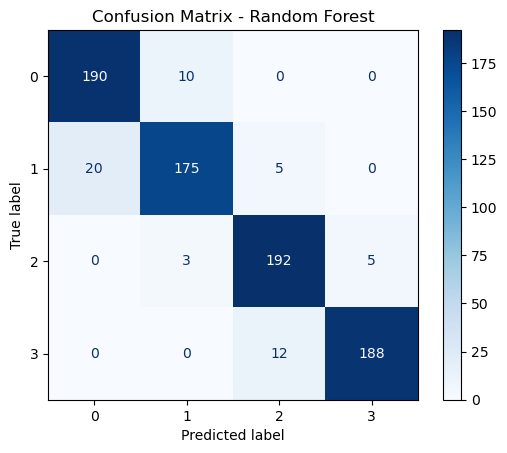


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       200
           1       0.93      0.88      0.90       200
           2       0.92      0.96      0.94       200
           3       0.97      0.94      0.96       200

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800



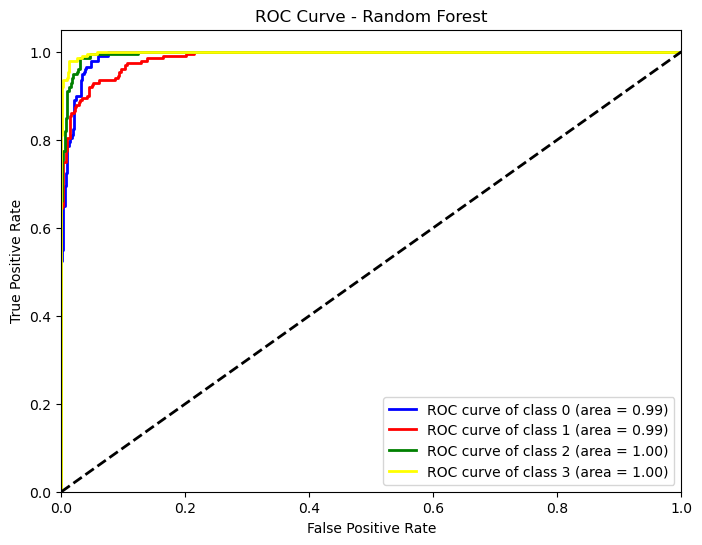

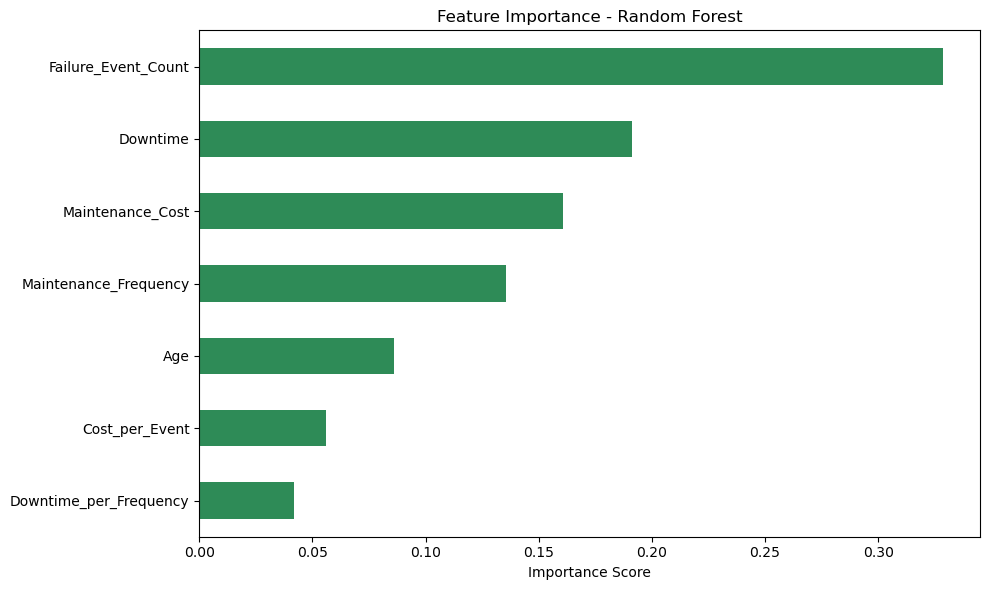

<Figure size 600x500 with 0 Axes>

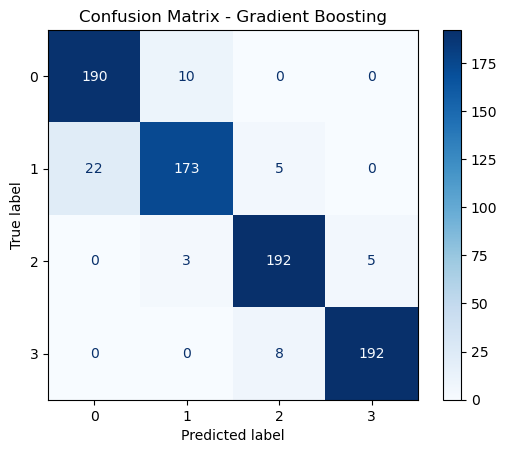


Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       200
           1       0.93      0.86      0.90       200
           2       0.94      0.96      0.95       200
           3       0.97      0.96      0.97       200

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800



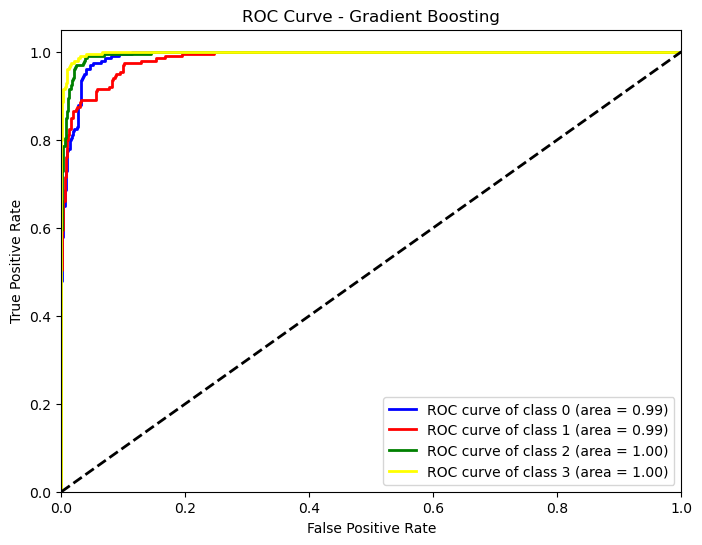

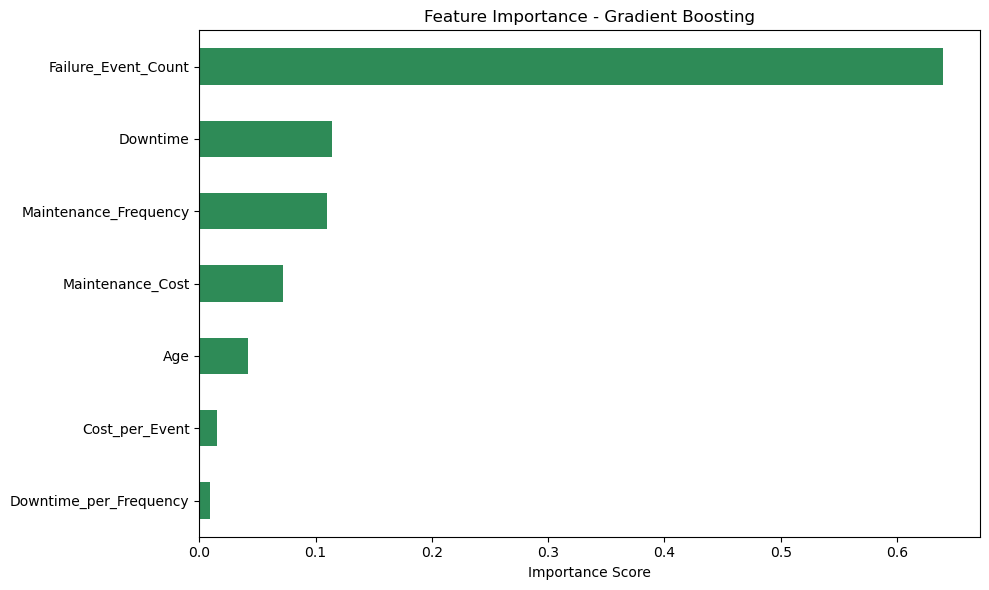

<Figure size 600x500 with 0 Axes>

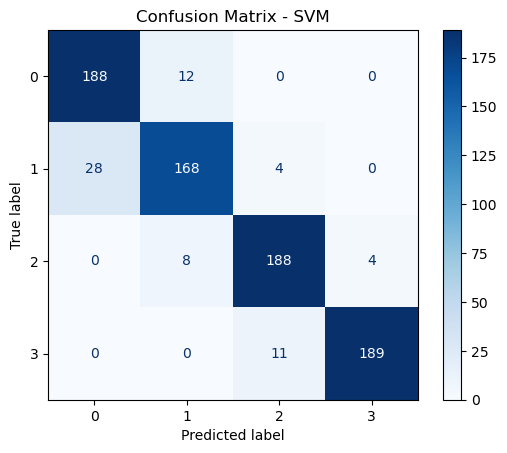


Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       200
           1       0.89      0.84      0.87       200
           2       0.93      0.94      0.93       200
           3       0.98      0.94      0.96       200

    accuracy                           0.92       800
   macro avg       0.92      0.92      0.92       800
weighted avg       0.92      0.92      0.92       800



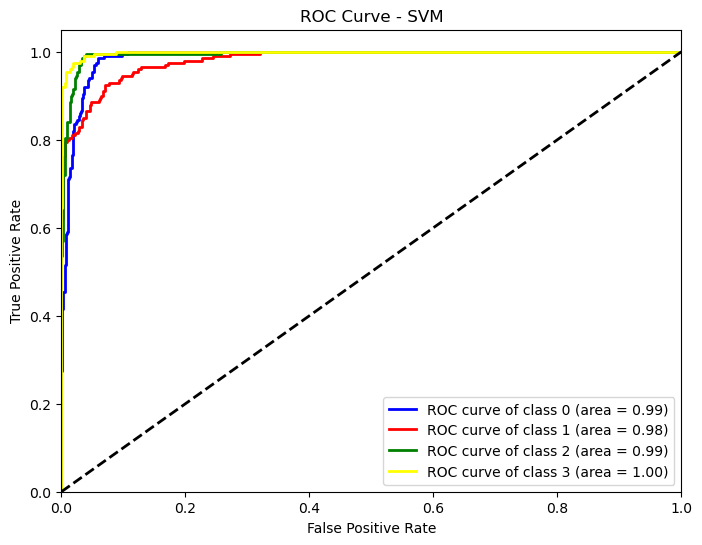

<Figure size 600x500 with 0 Axes>

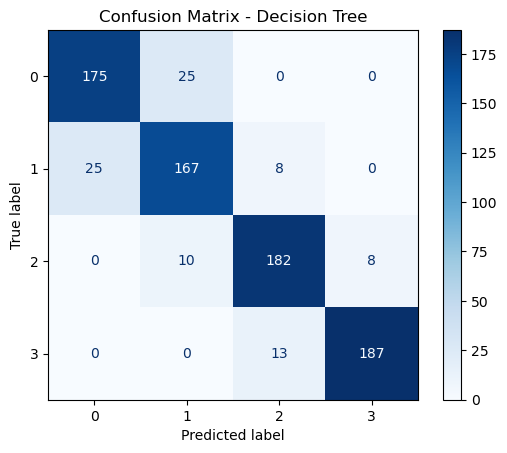


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       200
           1       0.83      0.83      0.83       200
           2       0.90      0.91      0.90       200
           3       0.96      0.94      0.95       200

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800



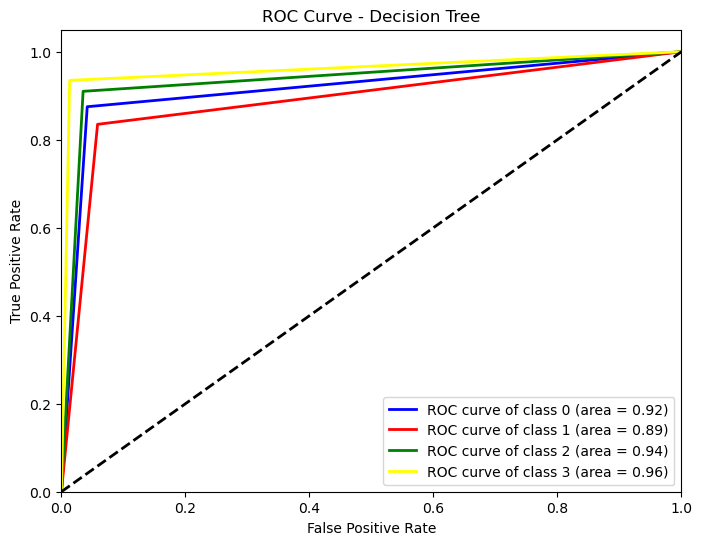

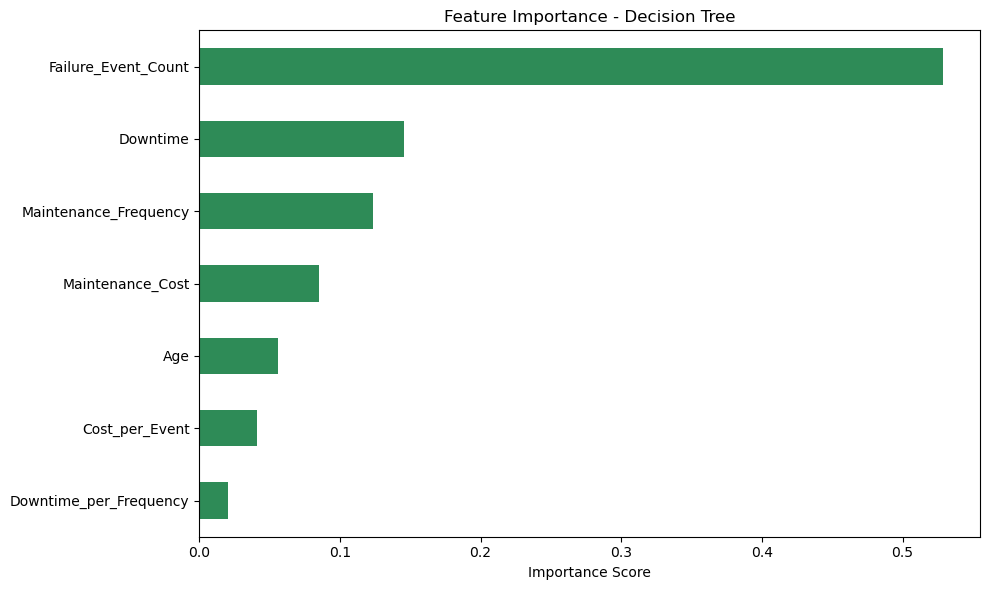

<Figure size 600x500 with 0 Axes>

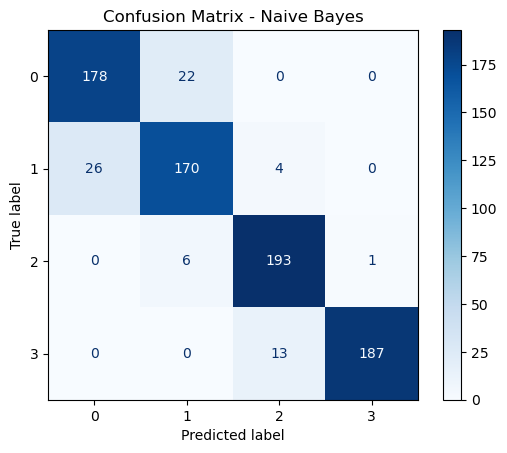


Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       200
           1       0.86      0.85      0.85       200
           2       0.92      0.96      0.94       200
           3       0.99      0.94      0.96       200

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800



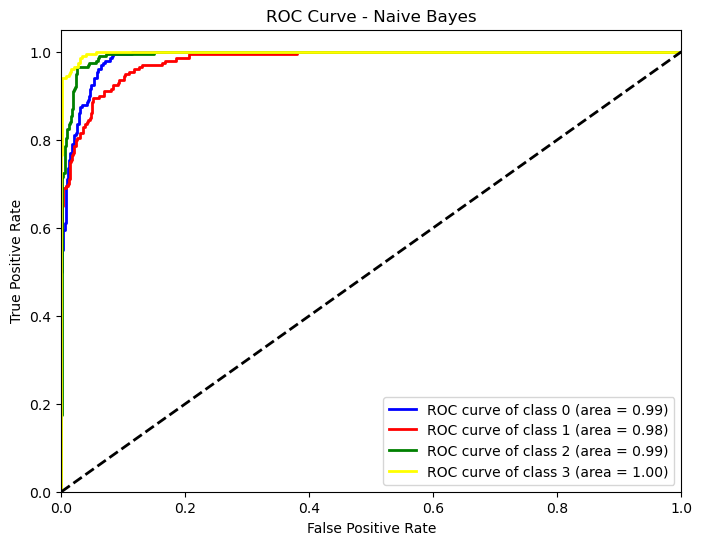


Training Weighted Ensemble Model...

Weighted Ensemble Model Performance:
 Accuracy: 93.62%
 Precision: 93.71%
 Recall: 93.62%
 F1 Score: 93.62%

Model saved as 'ensemble_model.pkl'


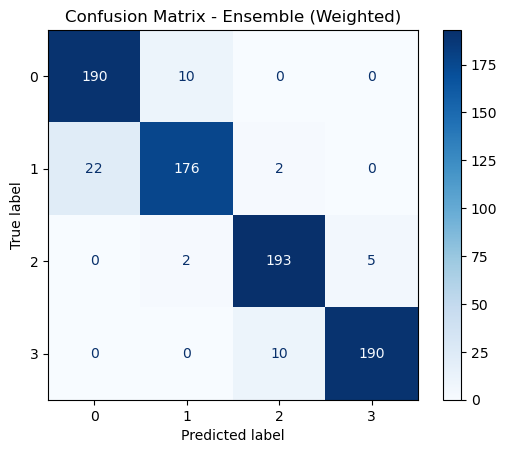


Classification Report for Ensemble:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       200
           1       0.94      0.88      0.91       200
           2       0.94      0.96      0.95       200
           3       0.97      0.95      0.96       200

    accuracy                           0.94       800
   macro avg       0.94      0.94      0.94       800
weighted avg       0.94      0.94      0.94       800



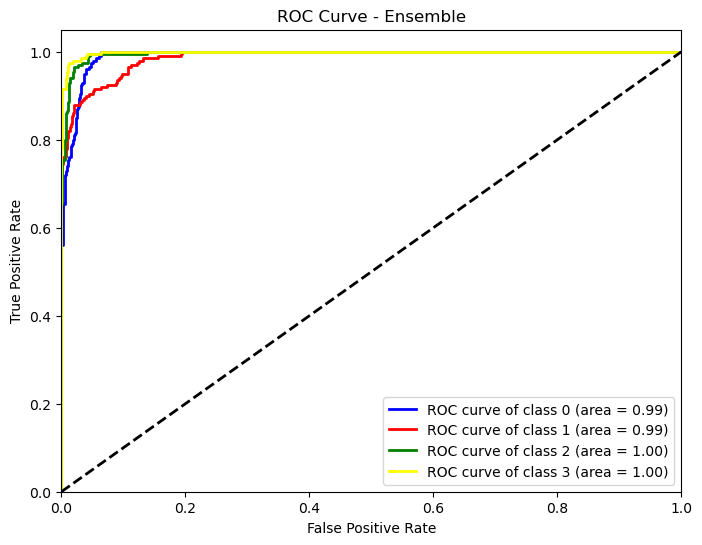

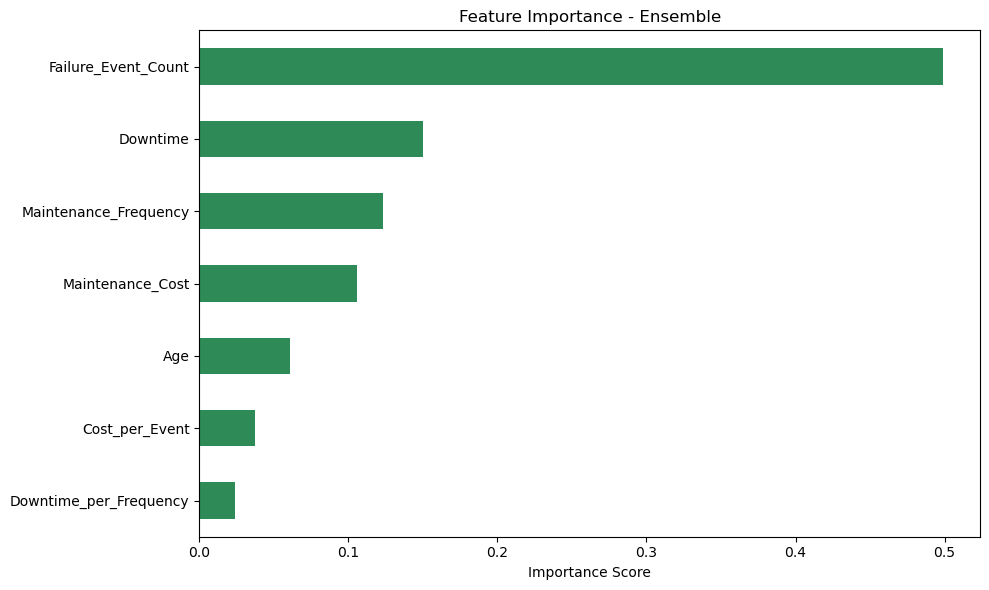


Comparing All Models...


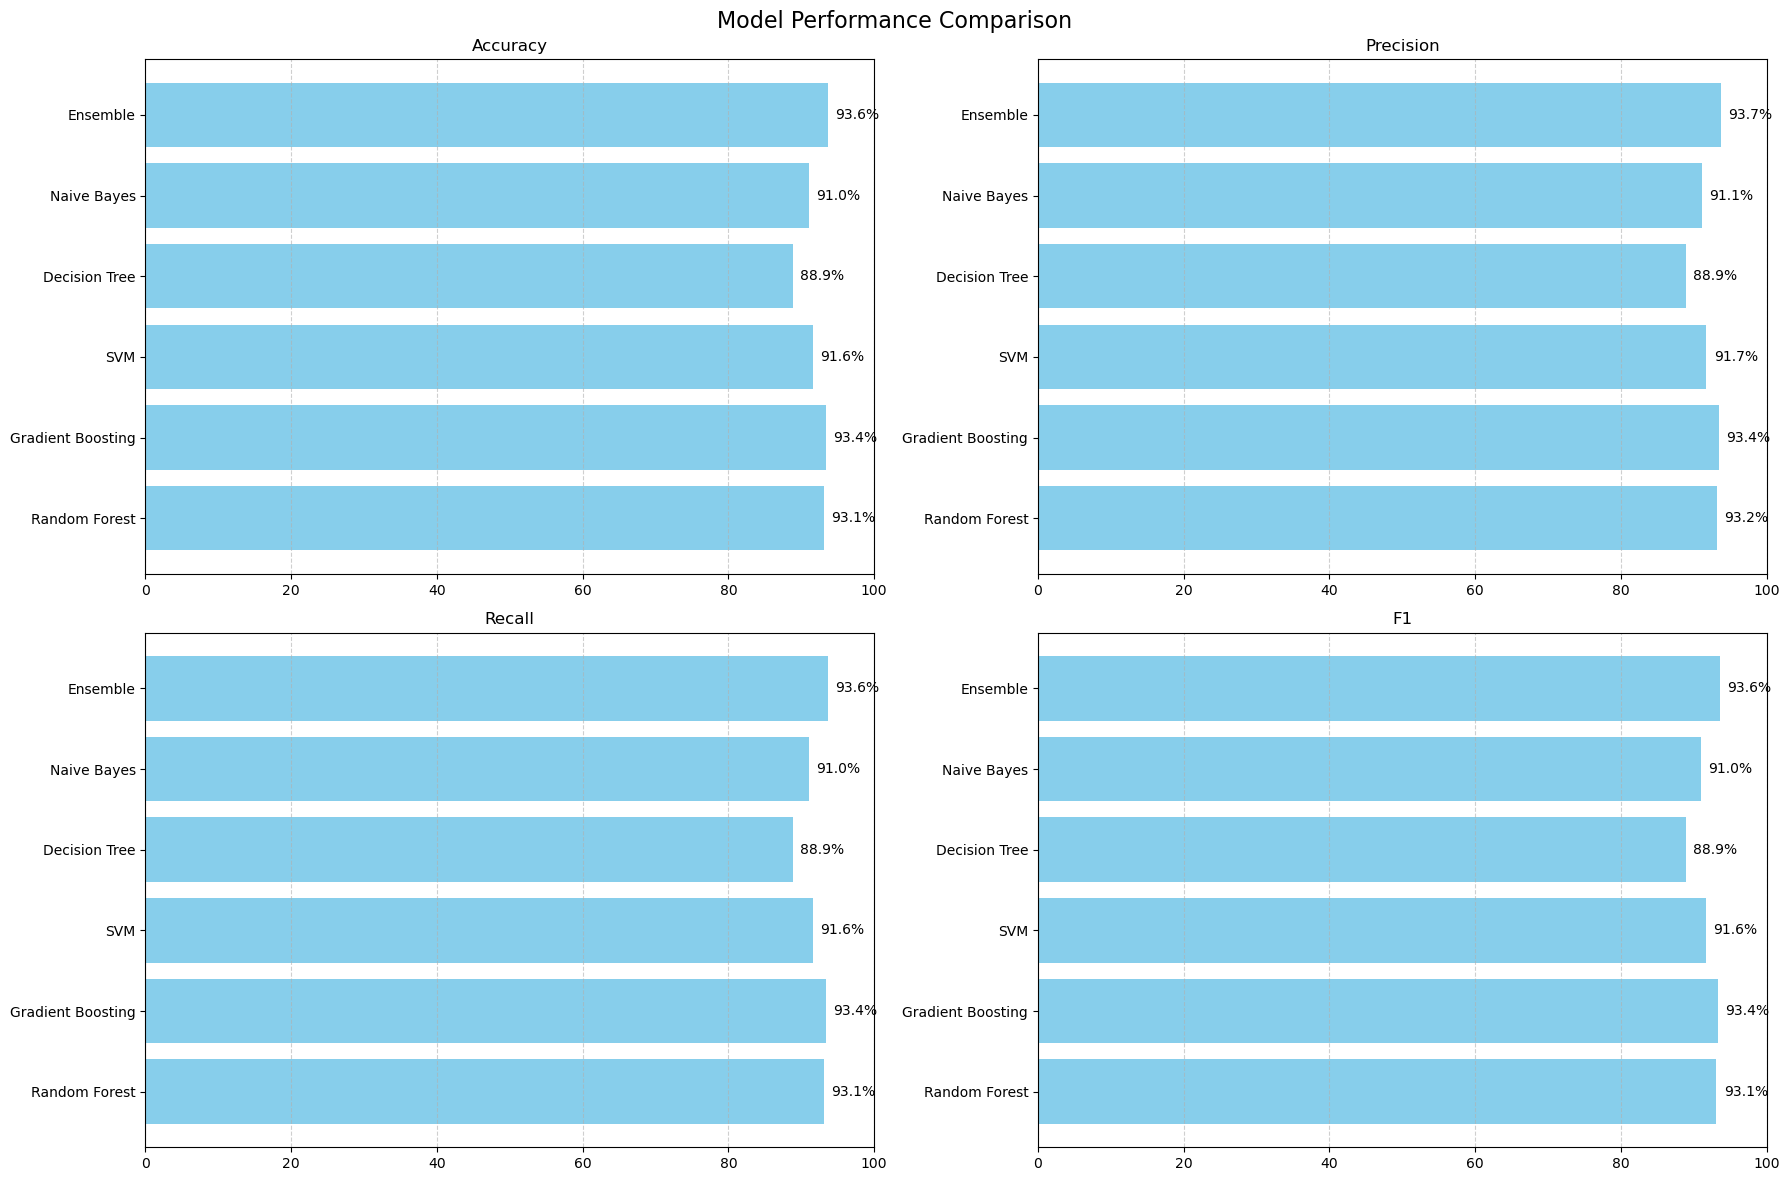

In [6]:

# -----------------------------
# 6. Main Execution
# -----------------------------
def main():
    print("Loading data...")
    df = load_dataset()

    print("Preprocessing...")
    X, y, features = preprocess(df)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    print("Evaluating Individual Models...")
    individual_results = evaluate_individual_models(X_train, X_test, y_train, y_test, features)
    
    print("\nTraining Weighted Ensemble Model...")
    all_results = train_evaluate_ensemble(X_train, X_test, y_train, y_test, features, individual_results)
    
    print("\nComparing All Models...")
    plot_model_comparison(all_results)

if __name__ == "__main__":
    main()